In [66]:
import numpy as np
import pandas as pd
import warnings
import ast
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

tokenized_data = pd.read_csv("DATA/tokenized_data.csv")
tokenized_data['tokens_no_stop'] = tokenized_data['tokens_no_stop'].apply(ast.literal_eval)
# Build one document per song (join token list back into text)
tokenized_data['joined_lyrics'] = tokenized_data['tokens_no_stop'].apply(lambda tokens: ' '.join(tokens))
# Vectorize song lyrics
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, max_features=5000)
tfidf_matrix = vectorizer.fit_transform(tokenized_data['joined_lyrics'])

# Apply NMF to extract topics
nmf = NMF(n_components=10, random_state=0)
topic_matrix = nmf.fit_transform(tfidf_matrix)  # shape: (n_songs, 10)

# Optional: assign dominant topic per song
tokenized_data['topic'] = topic_matrix.argmax(axis=1)


communities = pd.read_csv("DATA/communities.csv")
communities_df = pd.DataFrame(communities)

# ─── 1) MERGE TOKENS WITH COMMUNITY ───────────────────────────────────────────────
# Explode songs into one row per token
exploded = tokenized_data.explode('tokens_no_stop')\
    .rename(columns={'tokens_no_stop': 'token'})

# Join community labels
merged = exploded.merge(communities_df, on='song_id', how='inner')  # :contentReference[oaicite:0]{index=0}:contentReference[oaicite:1]{index=1}

# ─── 2) FLATTEN INTO PER-COMMUNITY DOCUMENTS ─────────────────────────────────────
# Combine all tokens for each community into one big list
community_docs_df = (
    merged.groupby('community_id')['token']
          .apply(list)
          .reset_index(name='tokens')
)

top_communities = (
    communities_df.groupby('community_id')['primary_artist']
      .nunique()
      .sort_values(ascending=False)
      .head(10)
      .index
      .tolist()
)

# Filter to top communities
community_docs_df = community_docs_df[
    community_docs_df['community_id'].isin(top_communities)
]

# ─── 3) COUNT TOKENS PER COMMUNITY ───────────────────────────────────────────────
# Explode back out so we can count
df_exploded = community_docs_df.explode('tokens')\
    .rename(columns={'tokens':'token'})

token_counts = (
    df_exploded
      .groupby(['community_id','token'])
      .size()
      .reset_index(name='count')
)  # :contentReference[oaicite:2]{index=2}:contentReference[oaicite:3]{index=3}

# ─── 4) COMPUTE TF ────────────────────────────────────────────────────────────────
# Total tokens per community
total_per_comm = (
    token_counts
      .groupby('community_id')['count']
      .sum()
      .reset_index(name='total_tokens')
)
tokens_count = token_counts.merge(total_per_comm, on='community_id')
tokens_count['tf'] = tokens_count['count'] / tokens_count['total_tokens']  # :contentReference[oaicite:4]{index=4}:contentReference[oaicite:5]{index=5}

# ─── 5) COMPUTE IDF ───────────────────────────────────────────────────────────────
# Document frequency: in how many communities each token appears
df_token_comm = (
    tokens_count
      .groupby('token')['community_id']
      .nunique()
      .reset_index(name='df_comm')
)
N = tokens_count['community_id'].nunique()
tokens_count = tokens_count.merge(df_token_comm, on='token')
tokens_count['idf'] = np.log(N / tokens_count['df_comm'])  # :contentReference[oaicite:6]{index=6}:contentReference[oaicite:7]{index=7}

# ─── 6) COMPUTE TF-IDF ────────────────────────────────────────────────────────────
tokens_count['tf_idf'] = tokens_count['tf'] * tokens_count['idf']

# ─── 7) PRINT TOP 10 PER COMMUNITY ───────────────────────────────────────────────
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=DeprecationWarning)

    top10 = (
        tokens_count[tokens_count['community_id'].isin(top_communities)]
          .groupby('community_id', group_keys=False)
          .apply(lambda grp: grp.nlargest(10, 'tf_idf'))
          .reset_index(drop=True)
    )  # :contentReference[oaicite:8]{index=8}:contentReference[oaicite:9]{index=9}

for comm_id, grp in top10.groupby('community_id'):
    tf_str    = ', '.join(f"{tok}({val:.4f})"
                          for tok, val in grp.nlargest(10, 'tf')[['token','tf']].values)
    idf_str   = ', '.join(f"{tok}({val:.4f})"
                          for tok, val in grp.nlargest(10, 'idf')[['token','idf']].values)
    tfidf_str = ', '.join(f"{tok}({val:.4f})"
                          for tok, val in grp[['token','tf_idf']].values)
    print(f"Community {comm_id}:")
    print(f"  Top 10 TF:      {tf_str}")
    print(f"  Top 10 IDF:     {idf_str}")
    print(f"  Top 10 TF-IDF:  {tfidf_str}")
    print("--------------")


Community -1:
  Top 10 TF:      bumpin(0.0053), knife(0.0042), thrill(0.0026), classic(0.0014), charli(0.0014), lipgloss(0.0012), prick(0.0011), doo(0.0009), dutch(0.0006), von(0.0006)
  Top 10 IDF:     dutch(2.3026), von(2.3026), bumpin(1.6094), lipgloss(1.6094), prick(1.6094), doo(1.6094), classic(1.2040), charli(1.2040), thrill(0.9163), knife(0.3567)
  Top 10 TF-IDF:  bumpin(0.0086), thrill(0.0024), lipgloss(0.0019), prick(0.0017), classic(0.0017), charli(0.0016), knife(0.0015), doo(0.0015), dutch(0.0015), von(0.0015)
--------------
Community 0:
  Top 10 TF:      nigga(0.0022), niggas(0.0020), yaka(0.0010), moo(0.0006), slay(0.0006), pon(0.0005), jimmy(0.0004), looka(0.0004), rider(0.0004), cunt(0.0004)
  Top 10 IDF:     yaka(2.3026), slay(2.3026), pon(2.3026), jimmy(2.3026), looka(2.3026), rider(2.3026), cunt(2.3026), moo(1.6094), niggas(0.6931), nigga(0.5108)
  Top 10 TF-IDF:  yaka(0.0022), niggas(0.0014), slay(0.0013), nigga(0.0011), pon(0.0011), moo(0.0010), jimmy(0.0010), looka

Community 0 → 5501 tokens total
 ... now using top 75 tokens


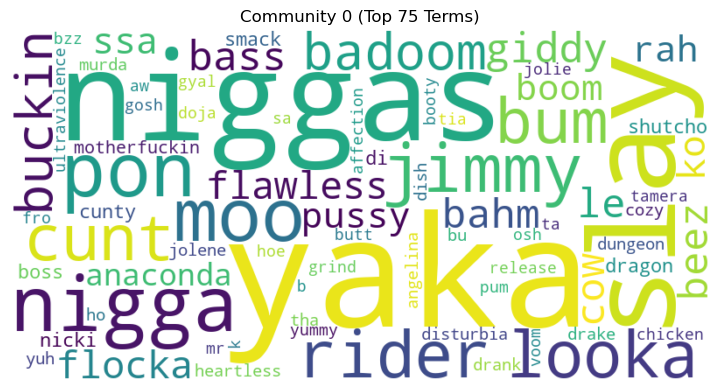

Community 1 → 1831 tokens total
 ... now using top 75 tokens


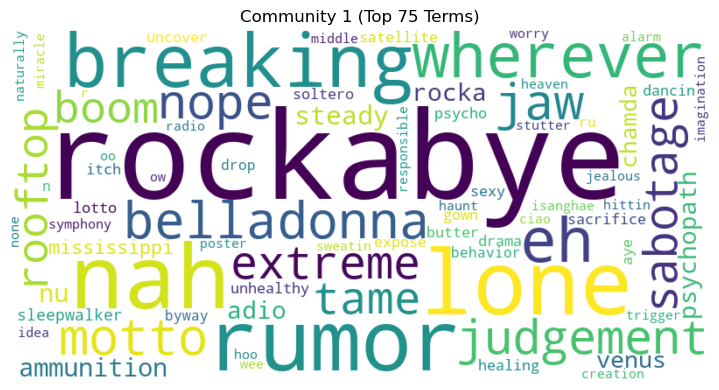

Community 3 → 2866 tokens total
 ... now using top 75 tokens


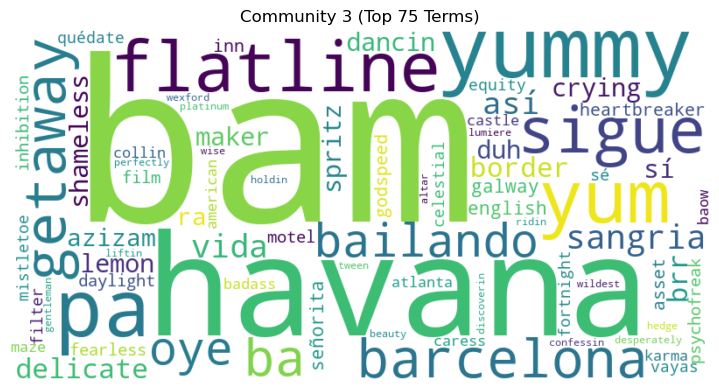

Community 2 → 1989 tokens total
 ... now using top 75 tokens


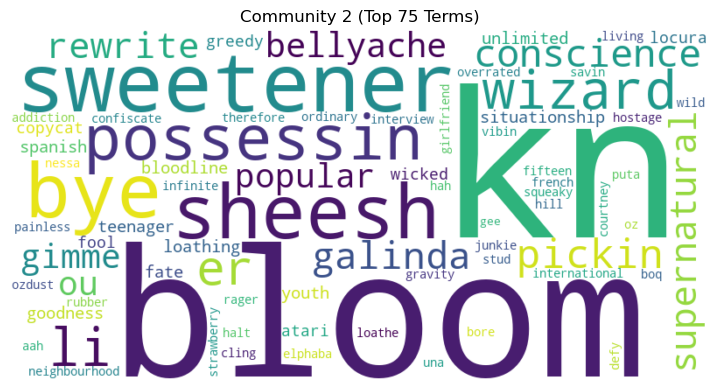

Community 4 → 1914 tokens total
 ... now using top 75 tokens


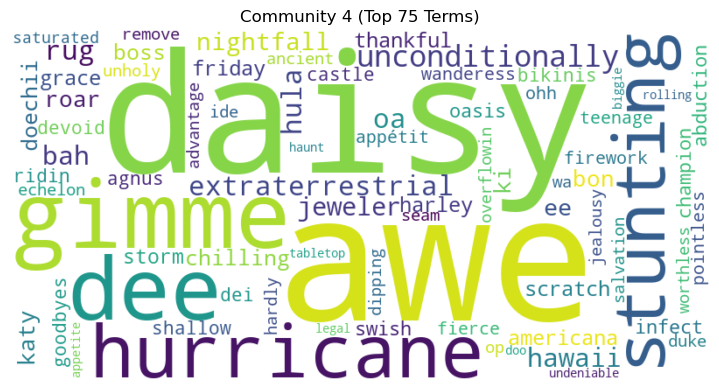

In [67]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

TOP_N = 75   # how many words to attempt in the cloud

for comm_id in top_communities[:5]:
    # 1) get all positive TF-IDF tokens
    freqs = (tokens_count
             .query("community_id == @comm_id and tf_idf > 0")
             .set_index('token')['tf_idf']
             .to_dict())
    print(f"Community {comm_id} → {len(freqs)} tokens total")

    # 2) take only the top TOP_N by weight
    top_items = sorted(freqs.items(), key=lambda x: x[1], reverse=True)[:TOP_N]
    top_freqs = dict(top_items)
    print(f" ... now using top {len(top_freqs)} tokens")

    if not top_freqs:
        print(f"⚠️ Skipping Community {comm_id} (no tokens).")
        continue

    try:
        wc = WordCloud(
            width=800,
            height=400,
            max_words=TOP_N,
            background_color='white',
            min_font_size=10,
            margin=2,
            prefer_horizontal=0.9
        ).generate_from_frequencies(top_freqs)

        plt.figure(figsize=(8,4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f"Community {comm_id} (Top {TOP_N} Terms)")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ WordCloud failed for community {comm_id}: {e}")
        # fallback bar chart
        series = pd.Series(top_freqs).sort_values(ascending=False)
        plt.figure(figsize=(6,3))
        series.plot(kind='barh', color='skyblue')
        plt.title(f"Community {comm_id} Top {TOP_N} TF-IDF Terms")
        plt.xlabel("TF-IDF")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


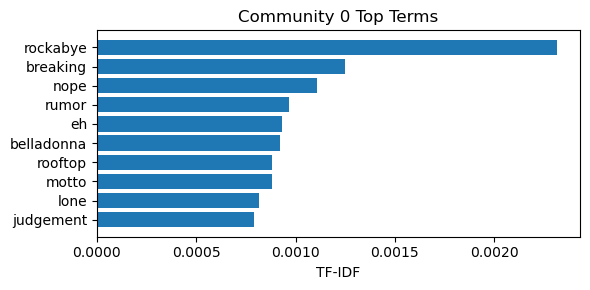

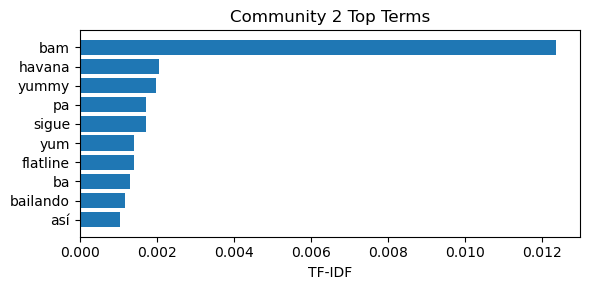

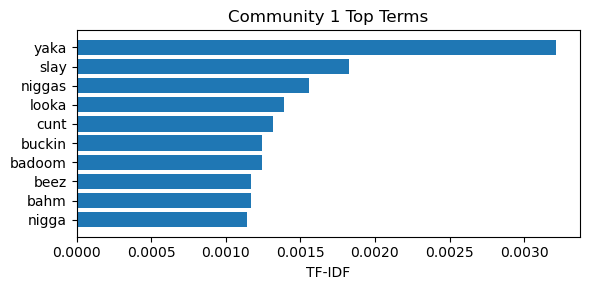

In [61]:
import matplotlib.pyplot as plt

for comm_id in top_communities[:3]:   # pick top 3 for space
    subset = (tokens_count.query("community_id==@comm_id")
                        .nlargest(10, 'tf_idf')
                        .sort_values('tf_idf'))
    plt.figure(figsize=(6,3))
    plt.barh(subset['token'], subset['tf_idf'])
    plt.xlabel("TF-IDF")
    plt.title(f"Community {comm_id} Top Terms")
    plt.tight_layout()
    plt.show()


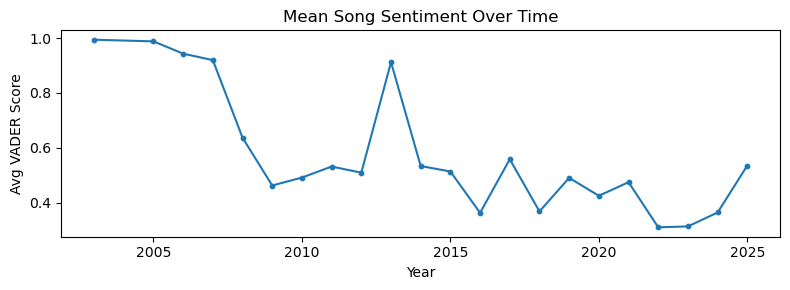

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

analyzer = SentimentIntensityAnalyzer()

df = pd.read_csv("DATA/spotify_genius_data_noduplicates.csv")

# Apply sentiment analysis to each lyric
df['sentiment'] = df['lyrics'].astype(str).apply(lambda text: analyzer.polarity_scores(text)['compound'])

# Parse dates robustly
df['year'] = pd.to_datetime(df['release_date'], format='mixed', errors='coerce').dt.year

# Drop rows with missing values
df = df.dropna(subset=['year', 'sentiment'])
df['year'] = df['year'].astype(int)

# Group and plot
yearly = df.groupby('year')['sentiment'].mean()
plt.figure(figsize=(8,3))
plt.plot(yearly.index, yearly.values)
plt.scatter(yearly.index, yearly.values, s=10)
plt.xlabel("Year"); plt.ylabel("Avg VADER Score")
plt.title("Mean Song Sentiment Over Time")
plt.tight_layout()
plt.show()


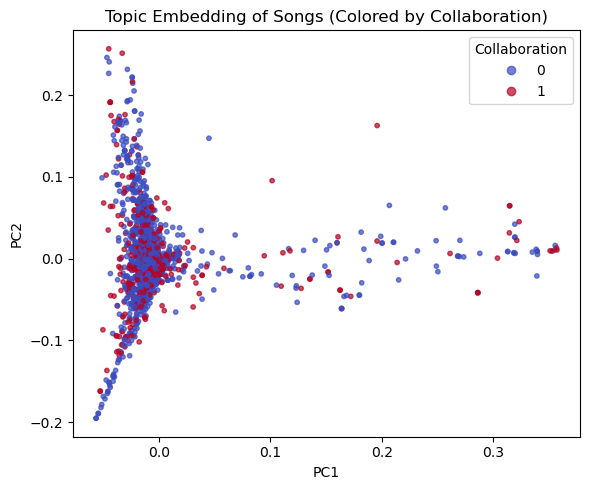

In [63]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

# Assume df_tracks holds your original metadata incl. 'is_collaboration'
# and topic_matrix has the topic embeddings

# Combine topic_matrix and metadata
topic_df = pd.DataFrame(topic_matrix, columns=[f"topic_{i}" for i in range(topic_matrix.shape[1])])
topic_df['is_collaboration'] = df['is_collaboration'].values  # make sure it's aligned by row index

# Run PCA
pca = PCA(n_components=2)
coords = pca.fit_transform(topic_matrix)

# Plot
plt.figure(figsize=(6, 5))
scatter = plt.scatter(coords[:, 0], coords[:, 1],
                      c=topic_df['is_collaboration'].map({True: 1, False: 0}),
                      cmap='coolwarm', s=10, alpha=0.7)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Topic Embedding of Songs (Colored by Collaboration)")
plt.legend(*scatter.legend_elements(), title="Collaboration")
plt.tight_layout()
plt.show()



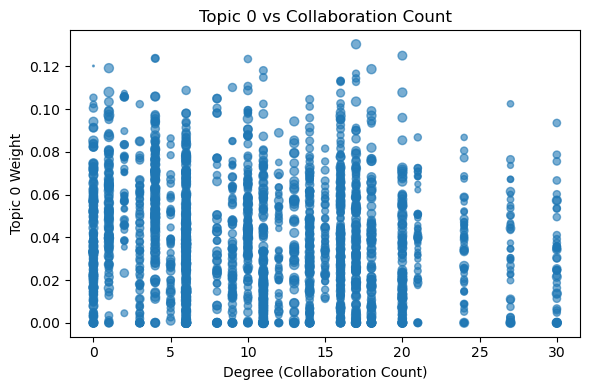

In [65]:
# Load your data (if not already)
df_tracks = pd.read_csv("DATA/spotify_genius_data_noduplicates.csv")
communities_df = pd.read_csv("DATA/communities.csv")

df = df_tracks.rename(columns={'spotify_id': 'song_id'})

# Merge to bring in the degree (collaboration count)
df_merged = df.merge(communities_df[['song_id', 'degree']], on='song_id', how='inner')

# Plot using degree as num_collaborations
plt.figure(figsize=(6,4))
plt.scatter(df_merged['degree'], topic_matrix[:, 0],
            s=(df_merged['popularity'] / 2), alpha=0.6)
plt.xlabel("Degree (Collaboration Count)")
plt.ylabel("Topic 0 Weight")
plt.title("Topic 0 vs Collaboration Count")
plt.tight_layout()
plt.show()
